In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/LNS.xls
/kaggle/input/CSUS.xls


In [2]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
PATH = '/kaggle/input/'

In [3]:
whole_df = pd.read_excel(PATH+'LNS.xls')
whole_df.head()

,observation_date,Employment Level
0,2000-01-01,10298
1,2000-02-01,10379
2,2000-03-01,10341
3,2000-04-01,10384
4,2000-05-01,10349


In [4]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  243 non-null    datetime64[ns]
 1   Employment Level  243 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


In [5]:
whole_df.set_index('observation_date',inplace=True)

In [6]:
whole_df.tail()

,Employment Level
observation_date,
2019-11-01,9548
2019-12-01,9506
2020-01-01,9455
2020-02-01,9542
2020-03-01,9478


## Seperate X and Y

In [7]:
df = whole_df[:'2018']
test = whole_df['2018':]

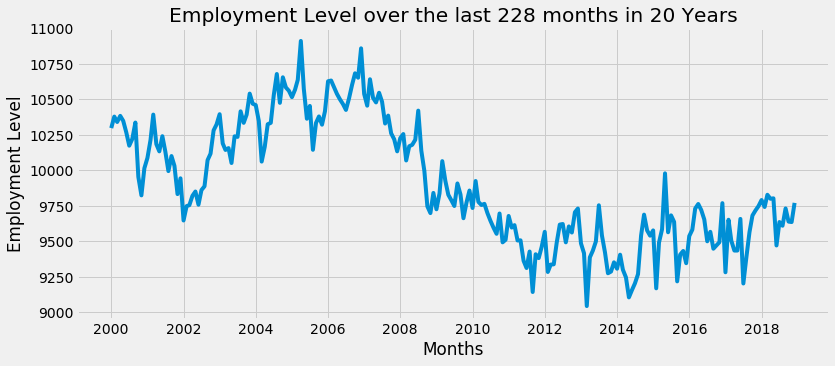

In [8]:
plt.figure(figsize=(12,5))
plt.title(f'Employment Level over the last {len(df)} months in 20 Years')
plt.xlabel('Months')
plt.ylabel('Employment Level')
plt.plot(df['Employment Level'])
plt.show()

In [9]:
def test_plot_stationarity(series):
    
    #Determing rolling statistics
    rolmean = series.rolling(window=12).mean()
    rolstd = series.rolling(12).std()

    plt.figure(figsize=(12,5))
    plt.plot(series,label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label = 'Rolling Std')
    plt.title('Rolling Mean & Std')
    plt.legend()
    plt.show()

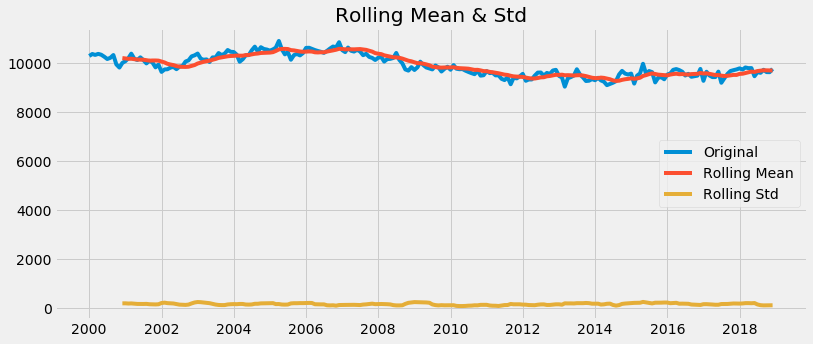

In [10]:
test_plot_stationarity(df['Employment Level'])

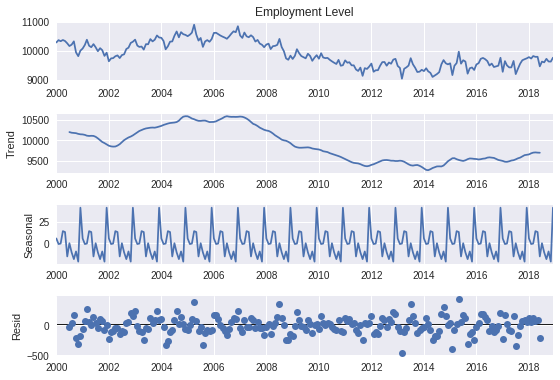

In [22]:
plt.style.use('seaborn')
seasonal_decomp=sm.tsa.seasonal_decompose(df['Employment Level'],model='add',freq=12)
# Freq=365 for daily, 4 for quarterly, 12 for monthly
fig=seasonal_decomp.plot()
plt.show()

# Stationay Series Test

In [23]:
# Dickey-Fuller test:
dftest = adfuller(df['Employment Level'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Stats','p-value','Lags Used','No. of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Stats                   -1.419570
p-value                       0.572859
Lags Used                     5.000000
No. of Observations Used    222.000000
Critical Value (1%)          -3.460154
Critical Value (5%)          -2.874649
Critical Value (10%)         -2.573757
dtype: float64


p-value is greater thab 0.05 so the series is not stationary. We have to find the right value od d which is either goind to be 1 or 2

## Find d
by using autocorrelation plots

In [24]:
def find_plot_diff_order(df):
    f,ax = plt.subplots(3,2,figsize=(15,12))
    ax = ax.ravel()
    
    ax[0].plot(df['Employment Level'])
    ax[0].set_title('Original')
    
    plot_acf(df['Employment Level'], ax=ax[1])

    # 1st Differencing
    ax[2].plot(df['Employment Level'].diff())
    ax[2].set_title('1st Order Differencing')
    
    plot_acf(df['Employment Level'].diff().dropna(), ax=ax[3])

    # 2nd Differencing
    ax[4].plot(df['Employment Level'].diff().diff())
    ax[4].set_title('2nd Order Differencing')
    
    plot_acf(df['Employment Level'].diff().diff().dropna(), ax=ax[5])
    
    plt.tight_layout()
    plt.show()

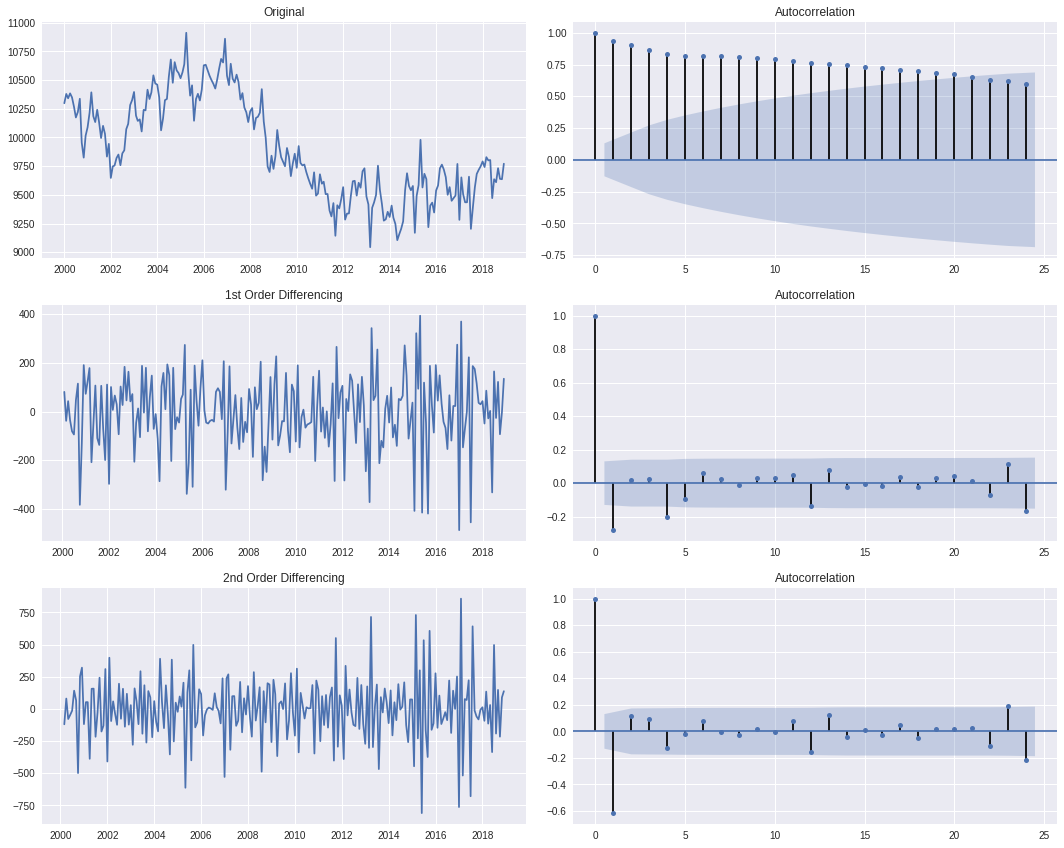

In [25]:
find_plot_diff_order(df)

with d=2, series looks overly differentiated and for d=1, series goes to stationary very quickly

## Find p
by using PACF Plot

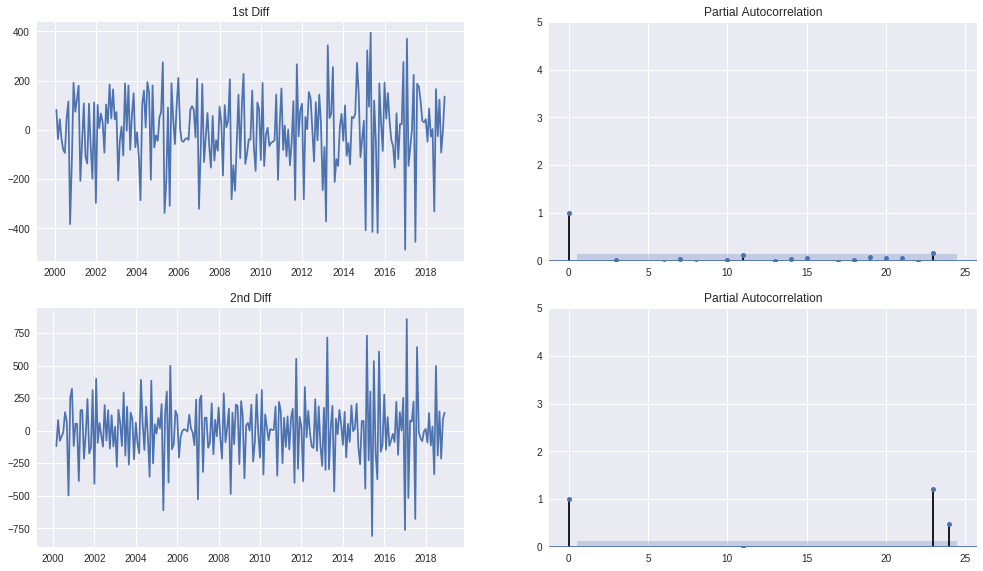

In [26]:
f, ax = plt.subplots(2, 2,figsize=(15,9))
ax = ax.ravel()

ax[0].plot(df['Employment Level'].diff())
ax[0].set_title('1st Diff')

ax[1].set(ylim=(0,5))
plot_pacf(df['Employment Level'].diff().dropna(), ax=ax[1])

ax[2].plot(df['Employment Level'].diff().diff().dropna())
ax[2].set_title('2nd Diff')

ax[3].set(ylim=(0,5))
plot_pacf(df['Employment Level'].diff().diff().dropna(), ax=ax[3])

plt.show()

lag=2 cross the significance line but 1 also does so merely for the last year. We can test with values 1 and 2 both

## Find q 
by using ACF plot

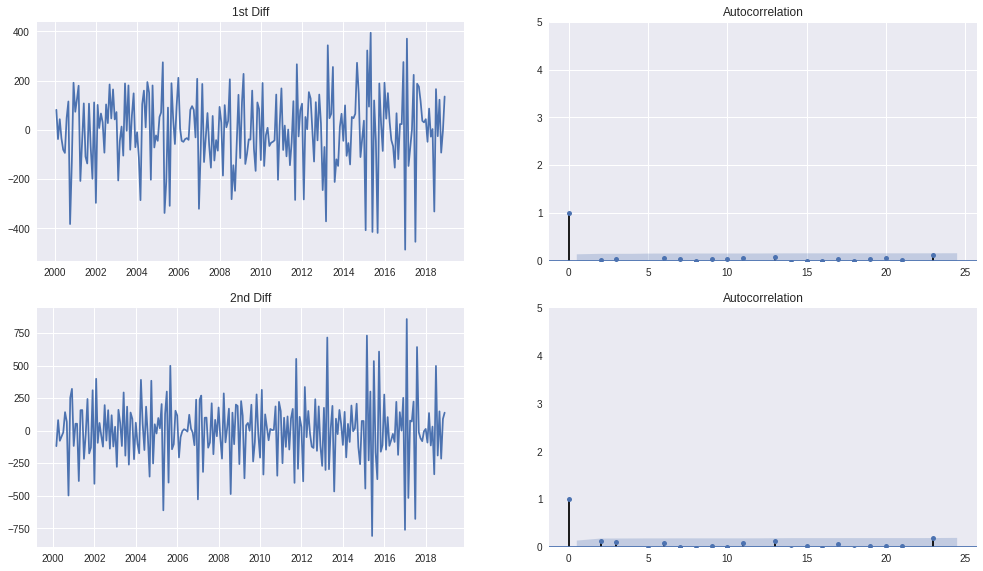

In [27]:
f, ax = plt.subplots(2, 2,figsize=(15,9))
ax = ax.ravel()

ax[0].plot(df['Employment Level'].diff())
ax[0].set_title('1st Diff')

ax[1].set(ylim=(0,5))
plot_acf(df['Employment Level'].diff().dropna(), ax=ax[1])

ax[2].plot(df['Employment Level'].diff().diff().dropna())
ax[2].set_title('2nd Diff')

ax[3].set(ylim=(0,5))
plot_acf(df['Employment Level'].diff().diff().dropna(), ax=ax[3])

plt.grid()
plt.show()


for both q=1 values are below the threshold line. In q=2, same thing is happening but it looks we have a few lines trying to emerge so will go with q=1

## Find p,q,d using SARIMAX GridSearch

In [28]:
p = d =q = range(2)
pdq = list(itertools.product(p, d, q)) # permutations of all p,q,d
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
# combinations of seasonal p,q,d. 12 is for yearly, 4 for quarterly

min_aic  = 9999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = SARIMAX(df['Employment Level'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,
                      enforce_invertibility=False)
        results = model.fit()
    
        if results.aic<min_aic:
            min_aic = results.aic
            print(f'p,d,q with values of {param}x{param_seasonal} produced AIC:{results.aic}')

p,d,q with values of (0, 0, 0)x(0, 0, 0, 12) produced AIC:4823.542803576964
p,d,q with values of (0, 0, 0)x(0, 0, 1, 12) produced AIC:4421.49310221936
p,d,q with values of (0, 0, 0)x(0, 1, 0, 12) produced AIC:3050.326216762718
p,d,q with values of (0, 0, 0)x(0, 1, 1, 12) produced AIC:2882.891987502144
p,d,q with values of (0, 0, 1)x(0, 1, 1, 12) produced AIC:2784.7223340973933
p,d,q with values of (0, 1, 0)x(0, 0, 1, 12) produced AIC:2763.4275277421802
p,d,q with values of (0, 1, 0)x(0, 1, 1, 12) produced AIC:2651.3581779790675
p,d,q with values of (0, 1, 0)x(1, 1, 1, 12) produced AIC:2651.0045901236035
p,d,q with values of (0, 1, 1)x(0, 1, 1, 12) produced AIC:2622.7380103748364
p,d,q with values of (1, 1, 1)x(0, 1, 1, 12) produced AIC:2619.961916770422
p,d,q with values of (1, 1, 1)x(1, 1, 1, 12) produced AIC:2619.7902479248296


p,d,q values of `(1,1,1)` gave us the minimum values of AIC so we will use those values

## Get insights 
From the optimal parameters fitted using SARIMAX

In [29]:
model = SARIMAX(df['Employment Level'],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5015,0.117,4.276,0.000,0.272,0.731
ma.L1,-0.8007,0.091,-8.759,0.000,-0.980,-0.622
ar.S.L12,-0.0568,0.055,-1.029,0.303,-0.165,0.051
ma.S.L12,-1.0000,0.093,-10.797,0.000,-1.182,-0.818
sigma2,2.223e+04,4.17e-06,5.34e+09,0.000,2.22e+04,2.22e+04


For all but L12, we have p-values less than the significance value

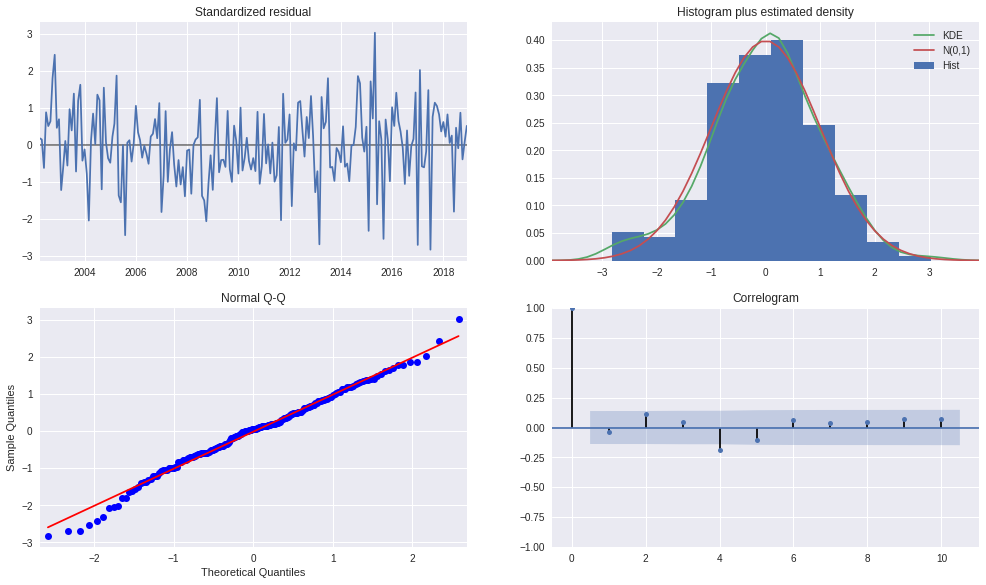

In [30]:
results.plot_diagnostics(figsize=(15,9))
plt.show()

## Build ARIMA

In [31]:
model = ARIMA(df['Employment Level'], order=(1,1,1))
model_fit = model.fit(disp=-1)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.Employment Level   No. Observations:                  227
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1453.944
Method:                       css-mle   S.D. of innovations            146.270
Date:                Fri, 08 May 2020   AIC                           2915.887
Time:                        01:53:42   BIC                           2929.587
Sample:                    02-01-2000   HQIC                          2921.415
                         - 12-01-2018                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.6432      3.923     -0.674      0.500     -10.333       5.047
ar.L1.D.Employment Level     0.4909      0.107      4.606      0.000       0.282       0.700
ma.L1.D.Employment Level    -0.7970      0.072    -11.061      0.000      -0.938      -0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0371           +0.0000j            2.0371            0.0000
MA.1            1.2547           +0.0000j            1.2547            0.0000
-----------------------------------------------------------------------------
"""

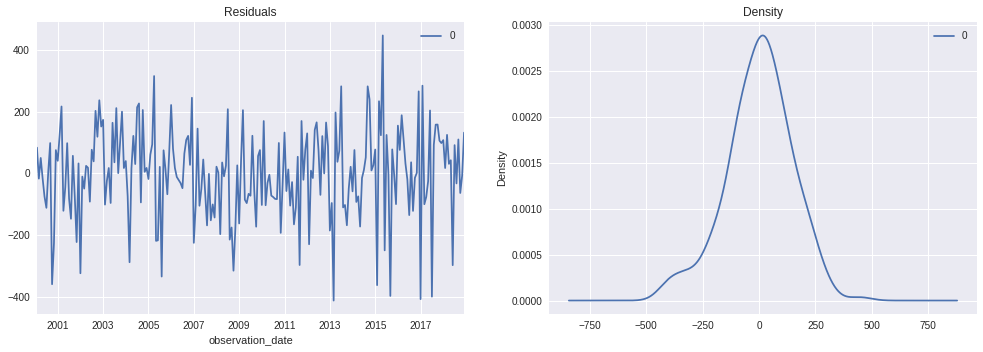

In [32]:
residuals = pd.DataFrame(model_fit.resid)

f, ax = plt.subplots(1,2,figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

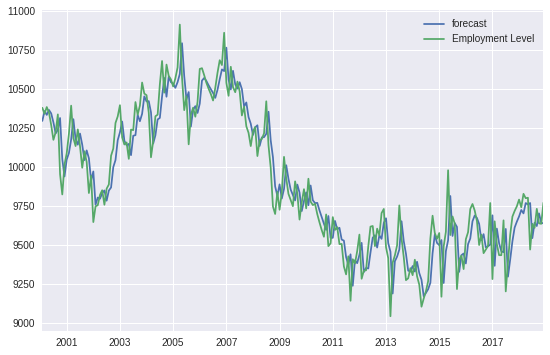

In [33]:
plt.style.use('seaborn')
model_fit.plot_predict(dynamic=False,)
plt.show()

## Fit and Predict

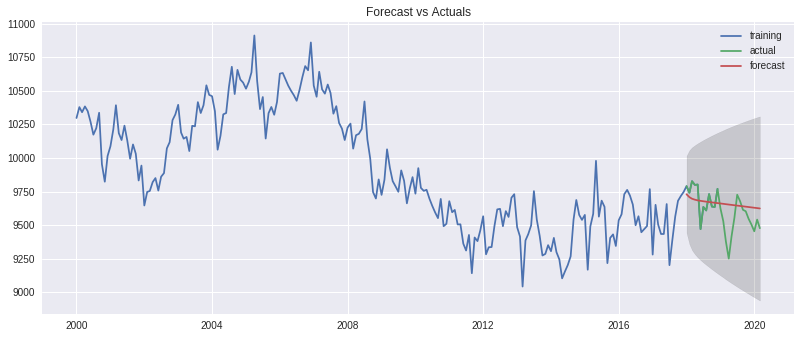

In [34]:
model = ARIMA(df['Employment Level'], order=(1,1,1))  
fitted = model.fit(disp=-1)  

fc, se, conf = fitted.forecast(27, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df['Employment Level'], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend()

In [35]:
mean_squared_error(test['Employment Level'].values,fc)

19556.12145825499